In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import gmplot

## Loading and wrangling of our dataset

In [2]:
# load the dataset
crimes = pd.read_csv('crime_data.csv')

### Data cleaning and dimensionality reduction

In [3]:
# Remove unused columns
crimes.drop(['Reporting District','Crime Code 1', 'Crime Code 2', 'Crime Code 3', 
             'Crime Code 4', 'Address', 'Cross Street'], axis=1, inplace=True)


# removes rows containing an unidentifiable status code and rows which do not contain a value
crimes.drop(crimes[(crimes['Status Code']=='CC') | (crimes['Status Code']=='13')
                  | (crimes['Status Code']=='19') | (crimes['Status Code']=='TH')].index, inplace=True)
crimes.drop(crimes[crimes['Status Code'].isnull()].index, inplace=True)

# remove rows where there is no premise code
crimes.drop(crimes[crimes['Premise Code'].isnull()].index, inplace=True)

# remove victims with a strange sex code and rows which do not contain a value
crimes.drop(crimes[(crimes['Victim Sex']=='H') | (crimes['Victim Sex']=='-')].index, inplace=True)
crimes.drop(crimes[crimes['Victim Sex'].isnull()].index, inplace=True)

# remove victims with '-' as victim descent and rows which do not contain a value
crimes.drop(crimes[(crimes['Victim Descent']=='-')].index, inplace=True)
crimes.drop(crimes[crimes['Victim Descent'].isnull()].index, inplace=True)

# If the Weapon Code is not given, this might either indicate that it is unknown or that there was no weapon
crimes['Weapon Used Code'].fillna(222.0, inplace=True)
crimes['Weapon Description'].fillna('Unknown/No Weapon', inplace=True)

# Drop rows without crime code description
crimes.drop(crimes[crimes['Crime Code Description'].isnull()].index, inplace=True)

# Drop rows without premise description ~3300
crimes.drop(crimes[crimes['Premise Description'].isnull()].index, inplace=True)

#convert date columns to date type (this takes a while)
crimes['Date Occurred'] = pd.to_datetime(crimes['Date Occurred'])
crimes['Date Reported'] = pd.to_datetime(crimes['Date Reported'])

# drop crimes that happend in 2018
crimes.drop(crimes[crimes['Date Occurred']>='01/01/2018'].index, inplace=True)

# Transform location column into two columns longitude and latitude. Location will be removed later on
locations = crimes['Location '].str.replace('(', '')
locations = locations.str.replace(')', '')
locations = locations.str.split(',')
longitude = []
latitude = []
for i, item in enumerate(locations):
    longitude.append(float(item[0]))
    latitude.append(float(item[1]))
    
crimes['Longitude'] = longitude
crimes['Latitude'] = latitude

crimes.drop(['Location '], axis=1, inplace=True)

# rows which contain longitude or latitude 0 will be removed, as they are not in LA 
crimes.drop(crimes[crimes['Longitude'] == 0].index, inplace=True)
crimes.drop(crimes[crimes['Latitude'] == 0].index, inplace=True)

## Analyzing the dataset using descriptiv statistics

As we have a quite big dataset with about 1.5 million crime incidents from 2010 to 2017, we want to focus on some attributes, which we think could be interesting. In the following we list the attributes that we want to take a closer look at, and some questions that came in to our mind, which we want to address. Some of these questions are already concerned with the correlation between certain attributes and will be treated in a seperate section.

- **Date Occurred** this attribute indicates when a crime incident has happend.
    - Is the crime rate in general increasing or decreasing over the years?
    - Is there a day on which more crimes happened?
   
   
- **Time Occurred** the time (in terms of hours and minutes) when a crime incident has happend. 
    - Is there a general trend when crimes occurr (maybe at night)?
    - Is there a relationship between specific types of crimes and time?
    
    
- **Crime Code/Description** the code identifying a crime type and its description (e.g. 310 Burglary)
    - What are the most common crimes?
    - Is there a relationship between the type of crimes and the date/time they are occurring?
    
    
- **Victim Age** the age of the victims (number between 10 and 99)
    - Is there an age group that is more likely to be the victims of a crime?
    - Is the age distribution changing over the years?


- **Victim Sex** the sex of the victims (Male, Female, Unknown)
    - Are males/females more often the victims of a crime?
    - Is there a relationship between certain types of crimes and the sex?
    
    
- **Victim Descent** the ethnic background of the victims (e.g. White, Black, Hispanic etc.)
    - Are people with a certain background more likely to be the victim of specific crimes?
    - How is age/sex and descent related in terms of specific crimes?
    

- **Weapon Used Code/Description** the code of the weapon used for a crime and its description (e.g. 102 Hand Gun)
    - What weapons are more used for which crimes
    - Did the use of weapons change over time (maybe the use of guns has increased)


- **Location** the location where the crime occurred rounded to the nearest 100 block (longitude and latitude)
    - Are there some general crime hotspots? (visualization on a map)
    - If there are hotspots, did they change over time?
    - Are specific crime types occurring more often in certain locations?
  
    

### A closer look on the attribute 'Date Occurred'

At first, we want to address how the crime rate is changing over the years. To do so we aggregate our attribute **Date Occurred** for each year and we will plot it by using a simple line chart. In this way we can see how the absolute number of crimes is increasing/decreasing over time.

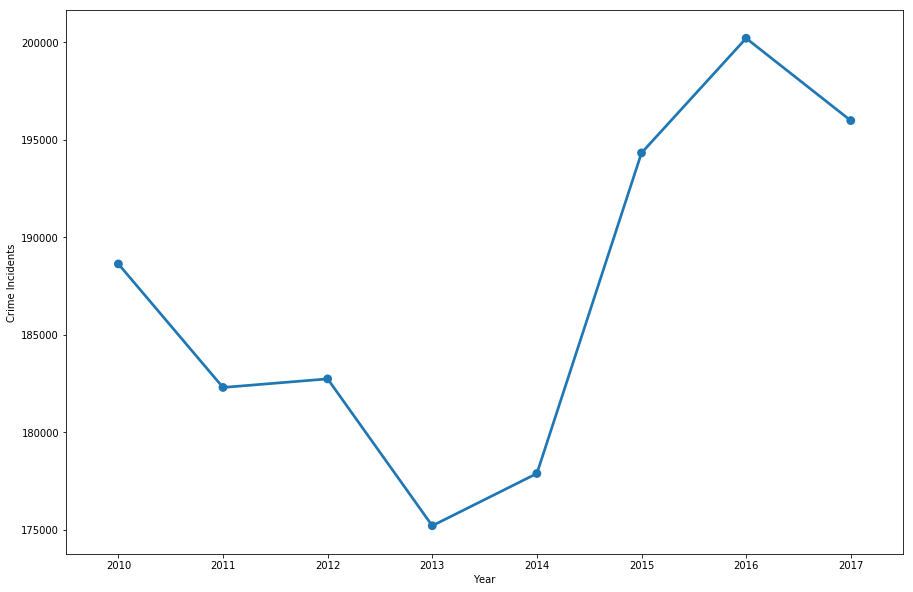

In [4]:
grouped_year = crimes.groupby([crimes['Date Occurred'].dt.year])
grouped_year = pd.DataFrame({'Crime Incidents' : grouped_year.size()}).reset_index()

plt.figure(figsize=(15,10))
ax = sns.pointplot(x = 'Date Occurred', y="Crime Incidents", data=grouped_year)
ax.set_xlabel('Year');

It seems that the number of crimes decreased from 2010 until 2013 and increased from 2013 until now.
TODO INTERPRET


The second thing we want to check is, if there is a certain day within the week where more crimes occurr. We do so in the same way as we have done befor, by grouping and using a line chart.

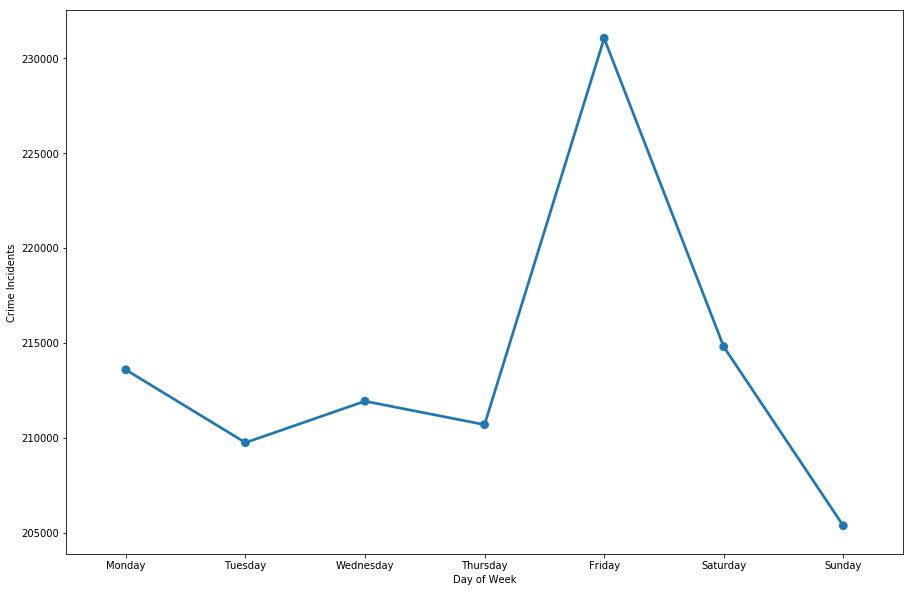

In [5]:
grouped_day = crimes.groupby([crimes['Date Occurred'].dt.weekday])
grouped_day = pd.DataFrame({'Crime Incidents' : grouped_day.size()}).reset_index()

plt.figure(figsize=(15,10))
ax = sns.pointplot(x="Date Occurred", y="Crime Incidents", data=grouped_day)
ax.set_xlabel('Day of Week')
ax.set_xticklabels(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']);

The plot shows a noticable increase for crimes on friday compared to the other days. This is interessting and there could be several explanations. It could be possible that there are more cases of battery on a friday as people are going out to pubs/bars/clubs, and drunk people are more likely to be involved in fights. It could be also the case that quite a lot people are away over the weekend which leaves there homes empty and could thus attract thiefs.
To find out what the real reason for this peak is, we have to take a closer look on the other attributes, to see if there is a correlation between any of them and the day of the week.

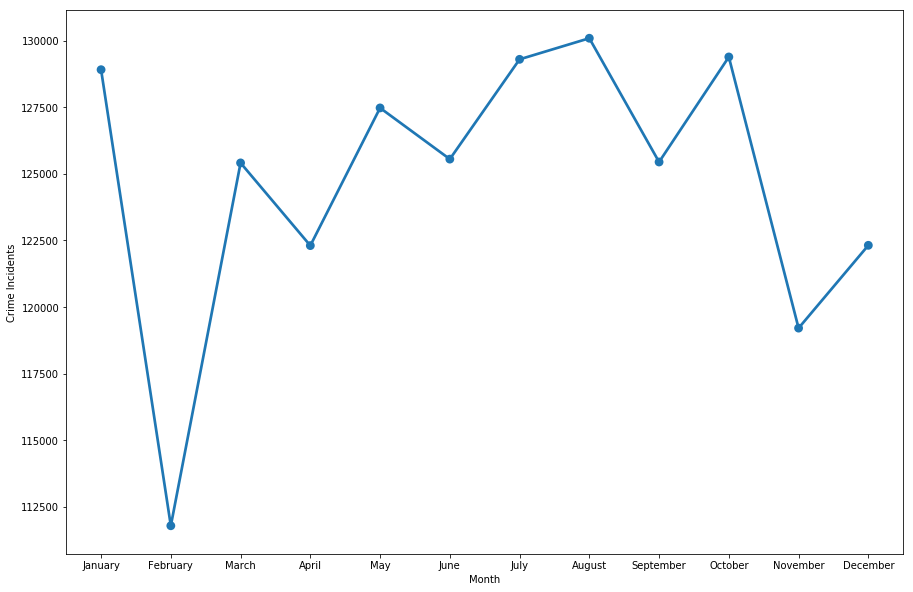

In [6]:
grouped_day = crimes['Date Occurred'].groupby([(crimes['Date Occurred'].dt.month)]).count()

grouped_day.index.names = ['Month']
grouped_day = grouped_day.reset_index()

grouped_day.columns = ['Month', 'Crime Incidents']

plt.figure(figsize=(15,10))
ax = sns.pointplot(x="Month", y="Crime Incidents", data=grouped_day)
ax.set_xticklabels(['January', 'February', 'March', 'April', 'May', 'June', 'July',
                    'August', 'September','October', 'November', 'December']);

TODO INTERPRET FEBRUARY shorter

### Analyzing the time when crimes are occurring

We want to know if there are certain times during a day, where crimes occurr more often. To analyse this, we 
map the time to full hours (14:30 will be mapped to 14:00 and 14:31 to 15:00). To see if there is a trend, we  will again use a simple line chart.

In [7]:
# map military times to full hour military times
def map_times(x):
    times = [30, 130, 230, 330, 430, 530, 630, 730, 830, 930, 1030, 1130, 
             1230, 1330, 1430, 1530, 1630, 1730, 1830, 1930, 2030, 2130, 2230, 2330]
    
    for i, time in enumerate(times):
        if x <= time:
            x = time - 30
            break
    
    if x > 2330:
        x=0
    return x


grouped_time = crimes['Time Occurred'].map(lambda x: map_times(x))
grouped_time = grouped_time.groupby(grouped_time)
grouped_time = pd.DataFrame({'Crime Incidents' : grouped_time.size()}).reset_index()

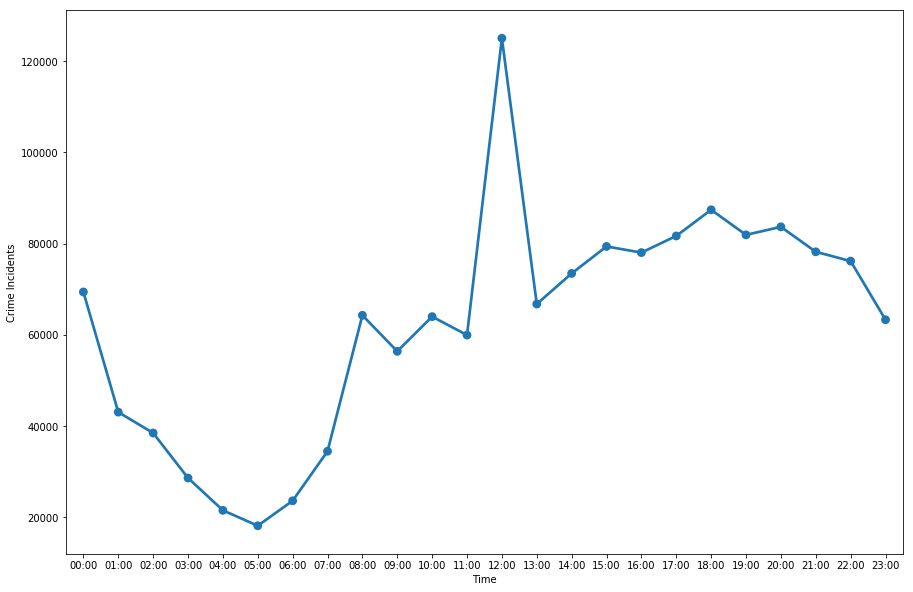

In [8]:
plt.figure(figsize=(15,10))
ax = sns.pointplot(x="Time Occurred", y="Crime Incidents", data=grouped_time)
ax.set_xlabel('Time')

ax.set_xticklabels(['00:00', '01:00', '02:00', '03:00', '04:00', '05:00', '06:00', '07:00', '08:00', '09:00', '10:00', '11:00',
                    '12:00', '13:00', '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00', '21:00', '22:00', '23:00']);

There is a significant and from our point of view a rather unplausible peak at 12 o'clock. 
TODO FURTHER INTERPRETATION

### Crime Code/Crime Code Description

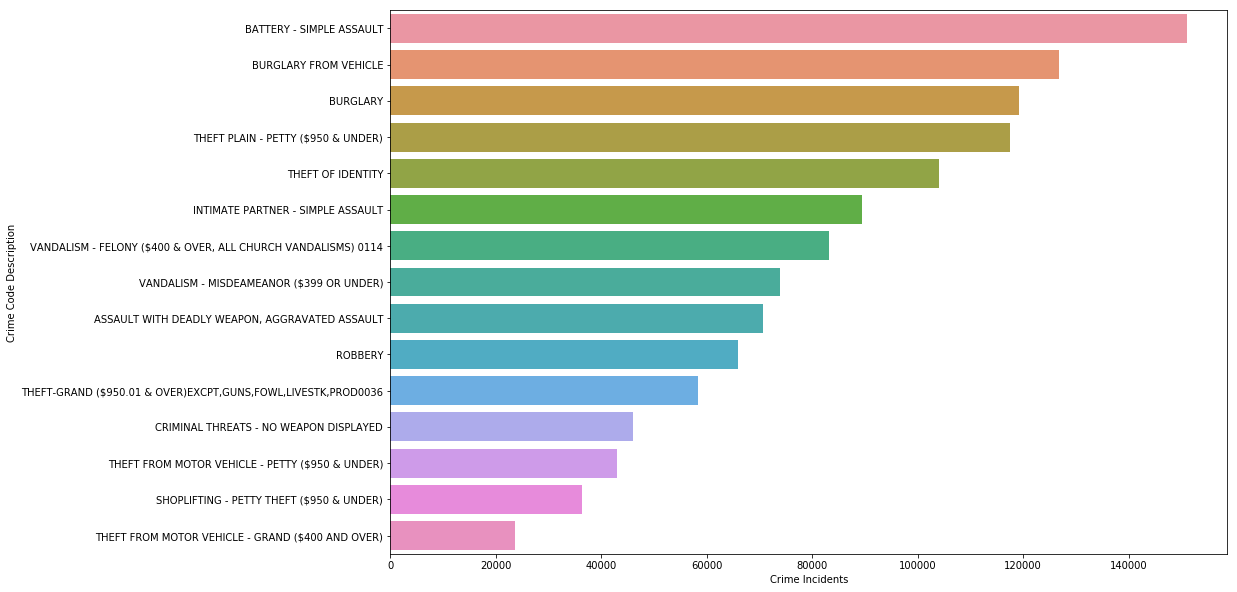

In [9]:
grouped_crimes = crimes[['Crime Code', 'Crime Code Description']].sort_values(['Crime Code']).groupby(['Crime Code', 'Crime Code Description'])

grouped_crimes = pd.DataFrame({'Crime Incidents' : grouped_crimes.size()}).reset_index().sort_values(ascending=False, by='Crime Incidents')

grouped_crimes[grouped_crimes['Crime Incidents']>10000]

plt.figure(figsize=(15,10))
sns.barplot(x='Crime Incidents', y='Crime Code Description', data=grouped_crimes.head(15));

Taking a closer look on the plot shows us, that Battery-Simple Assault is the most common crime with over 140000 incidents in 7 years, which means that there are on average more than cases each day.<br>
This plot should just show the major crimes, however it will be more interesting to see if there is any correlation between the type of crime and another attribute like sex/age/descent or the time.

### Taking a closer look on the age and sex of the victims
TODO Description, have we found something interesting?

In [10]:
@interact(year_from=(2010,2017,1),year_to=(2010,2017,1), sex=['M','F','Unknown','Male and Female', 'All'])
def show_distplot(year_from,year_to, sex):  
    if sex == 'All':
        filtered = crimes[(crimes['Victim Age']!=-1)]
    elif sex == 'Male and Female':   
        filtered = crimes[(crimes['Victim Age']!=-1)&((crimes['Victim Sex']=='M') | (crimes['Victim Sex']=='F'))]
    else:
        if sex == 'Unknown':
            sex = 'X'
        filtered = crimes[(crimes['Victim Age']!=-1)&(crimes['Victim Sex']==sex)]
    
    filtered = filtered[(filtered['Date Occurred'] >= '01/01/'+str(year_from))&
                        (filtered['Date Occurred'] <= '12/31/'+str(year_to))]
    filtered['Victim Age'].hist(bins=90, figsize=(10,8))
    
    

interactive(children=(IntSlider(value=2013, description='year_from', max=2017, min=2010), IntSlider(value=2013, description='year_to', max=2017, min=2010), Dropdown(description='sex', options=('M', 'F', 'Unknown', 'Male and Female', 'All'), value='M'), Output()), _dom_classes=('widget-interact',))

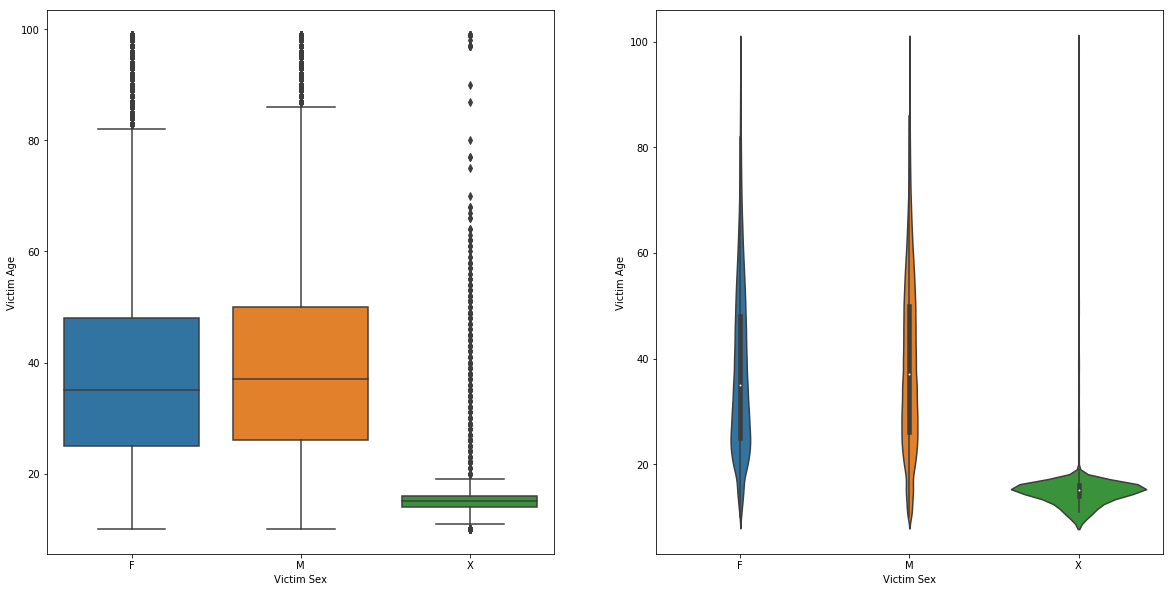

In [11]:
plt.figure(figsize=(20,10))
plt.subplot(121)
sns.boxplot(x='Victim Sex', y='Victim Age',data=crimes)

plt.subplot(122)
sns.violinplot(x='Victim Sex', y='Victim Age',data=crimes)

### Sex and Crime or who is more often victim of a crime
We have three sex classes, male(M), female(F) and unknown(X) and we want to know which class is more often the victim of a crime. To compare those we will use a bar chart.

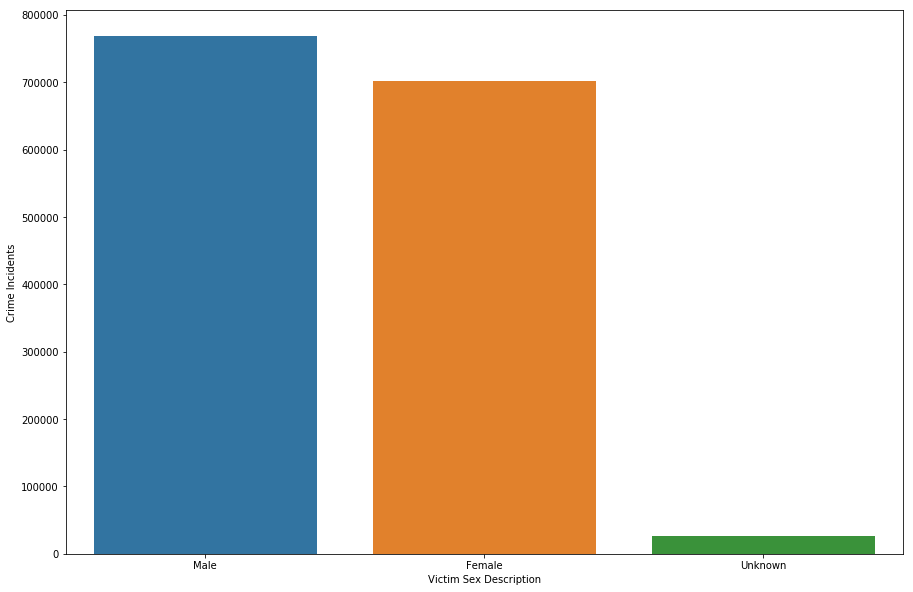

In [12]:
grouped_sex = crimes[['Victim Sex']].groupby(['Victim Sex'])
victim_sex_desc = [ 'Female', 'Male', 'Unknown']
grouped_sex = pd.DataFrame({'Crime Incidents' : grouped_sex.size(), 'Victim Sex Description':victim_sex_desc}).reset_index()
grouped_sex = grouped_sex.sort_values(ascending=False, by='Crime Incidents')

plt.figure(figsize=(15,10))
sns.barplot(x='Victim Sex Description', y='Crime Incidents', data=grouped_sex);

TODO INTERPRET

### Ethnical background and crime victims
We want to know, if people with a certain ethnical background are more likely to be victims of a crime.
To do so, we will again use a barplot, however from preliminary experiments we know that there are several descent-classes with a small number of incidents, which would distort the plot. We therefore decided to only show the seven major classes.

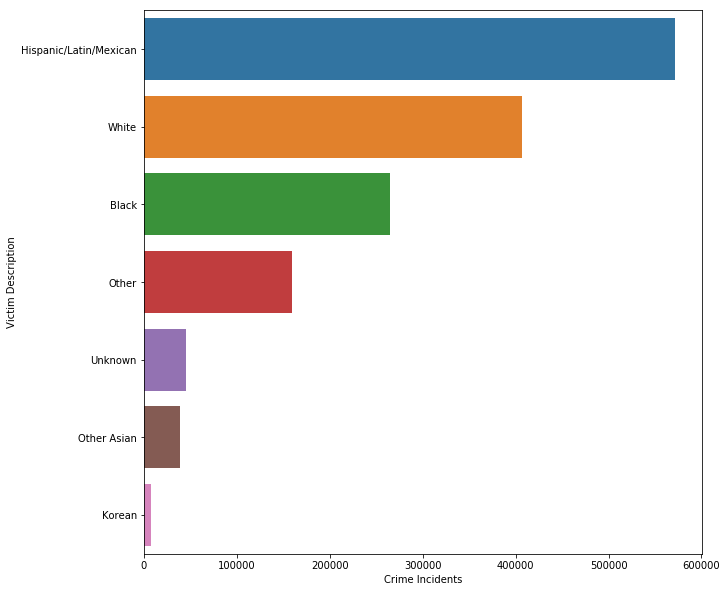

In [13]:
grouped_descent = crimes[['Victim Descent']].sort_values(['Victim Descent']).groupby(['Victim Descent'])
victim_descent_desc = ['Other Asian', 'Black','Chinese','Cambodian','Filipino','Guamanian',
                       'Hispanic/Latin/Mexican','American Indian/Alaskan Native', 'Japanese', 
                       'Korean', 'Laotian','Other', 'Pacific Islander', 'Samoan', 'Hawaiian', 
                       'Vietnamese', 'White', 'Unknown', 'Asian Indian']

grouped_descent = pd.DataFrame({'Crime Incidents' : grouped_descent.size(), 'Victim Description': victim_descent_desc}).reset_index()
grouped_descent = grouped_descent.sort_values('Crime Incidents', ascending=False)

plt.figure(figsize=(10, 10))
sns.barplot(x='Crime Incidents', y='Victim Description', data=grouped_descent.head(7));

TODO INTERPRET, say that la has probably a higher hispanic population

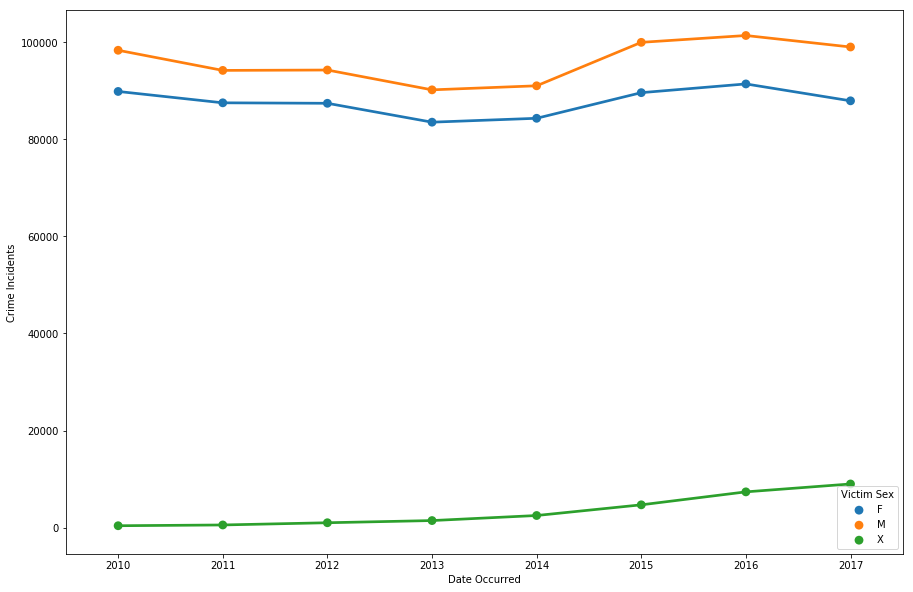

In [14]:
grouped = crimes.groupby([crimes['Date Occurred'].dt.year, crimes['Victim Sex']])
victims_sex = pd.DataFrame({'Crime Incidents' : grouped.size()}).reset_index()

victims_sex
plt.figure(figsize=(15,10))
sns.pointplot(x="Date Occurred", y="Crime Incidents", hue="Victim Sex", data=victims_sex)


### What weapons are in use


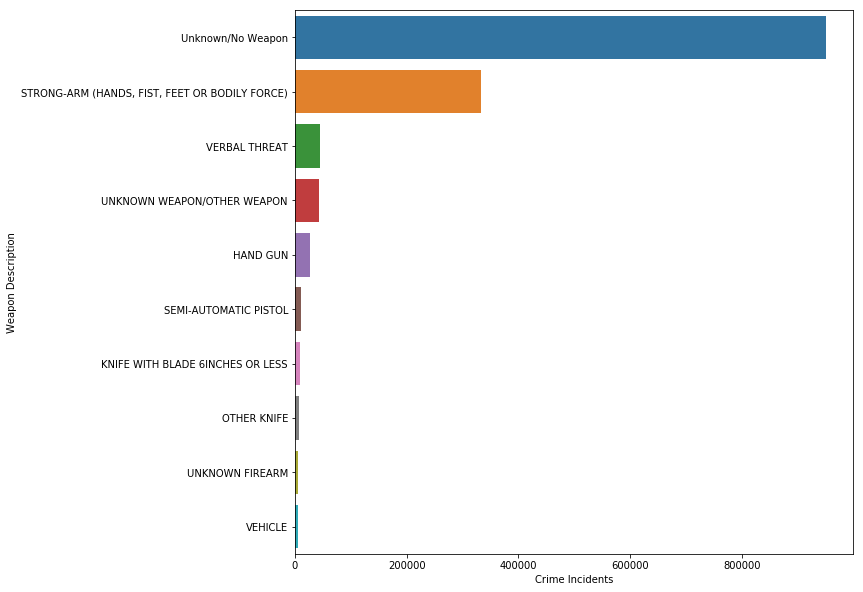

In [15]:
grouped_weapons = crimes[['Weapon Used Code', 'Weapon Description']].sort_values(['Weapon Used Code']).groupby(['Weapon Used Code', 'Weapon Description'])
grouped_weapons = pd.DataFrame({'Crime Incidents' : grouped_weapons.size()}).reset_index()
grouped_weapons = grouped_weapons.sort_values(ascending=False, by='Crime Incidents')


plt.figure(figsize=(10, 10))
sns.barplot(x='Crime Incidents', y='Weapon Description', data=grouped_weapons.head(10));

In the course of our data cleaning we assumed that if there is no information about a weapon given, that there was either no weapon used or it is just unknown. We therefore created a class 'Unknown/No Weapon' and it seems that for most crimes this is the case. TODO INTERPRET

### Where are crimes usually happening

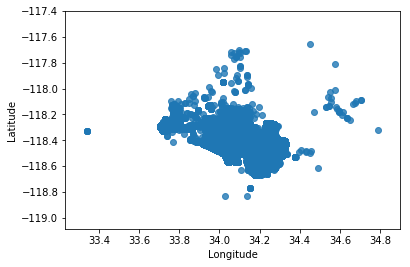

In [16]:
# gmap = gmplot.GoogleMapPlotter(33.428, -119.145, 12)
# colors = np.tile(['blue', 'red', 'green', 'yellow'], 250)
# gmap.scatter(longitude, latitude, 'yellow', size=70, marker=False)
# map.draw("mymap_scatter.html")
# gmap.heatmap(longitude, latitude, threshold = 50, radius = 30)
# gmap.draw("mymap.html")
import time

sns.regplot(x="Longitude", y="Latitude", data=crimes, fit_reg=False)


## Analyzing the dataset by looking at correlations between attributes
While analyzing the dataset with descriptiv statistics in the previous questions, we have seen some interesting patterns. We now want understand them better by loooking if there is some sort of correlation to other variables.

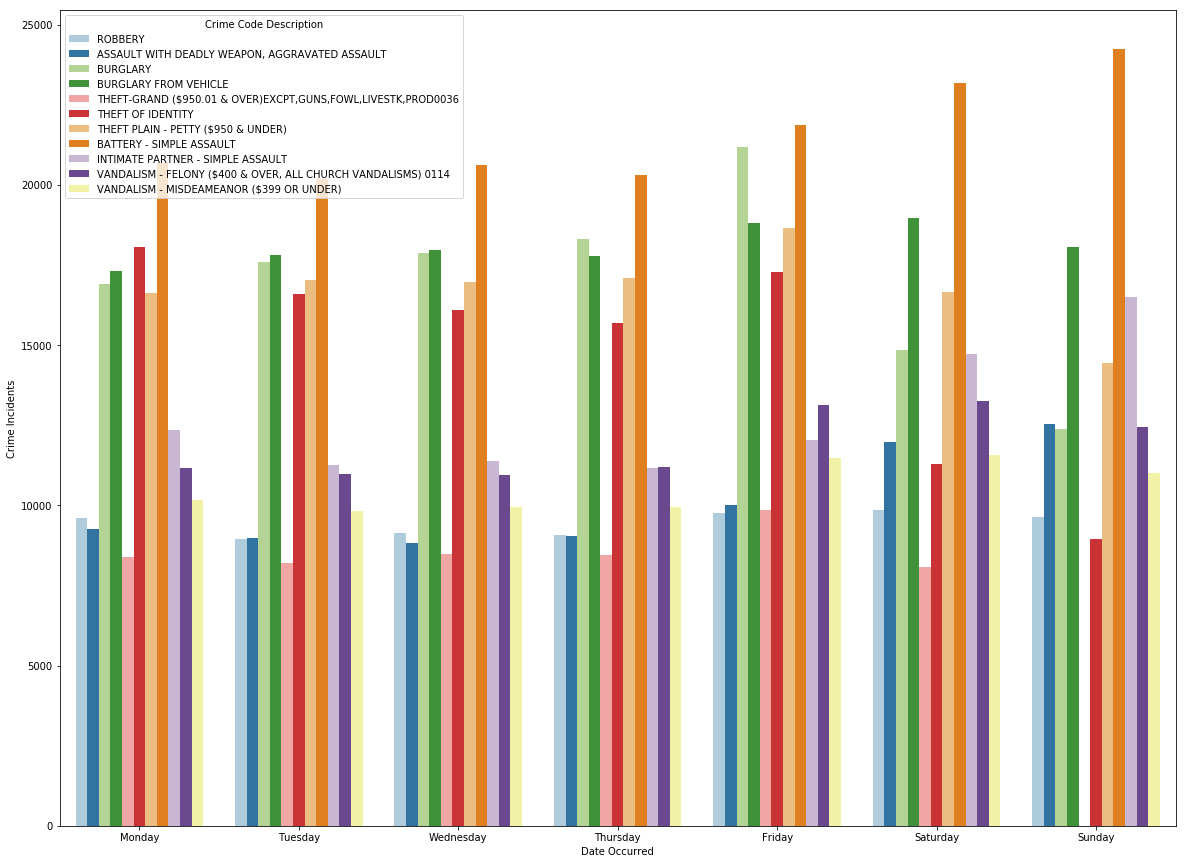

In [17]:
crime_day = crimes.groupby([crimes['Date Occurred'].dt.weekday, crimes['Crime Code'], crimes['Crime Code Description']])
crime_day = pd.DataFrame({'Crime Incidents' : crime_day.size()}).reset_index()


color_palette = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928']

plt.figure(figsize=(20, 15))
ax = sns.barplot( x='Date Occurred', y='Crime Incidents', hue='Crime Code Description',
            data=crime_day[crime_day['Crime Incidents']>8000], palette=color_palette)
ax.set_xticklabels(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']);

TODO INTERPRET, burglary increases on friday also battery. Intimate partner on sunday (maybe people are more at home)

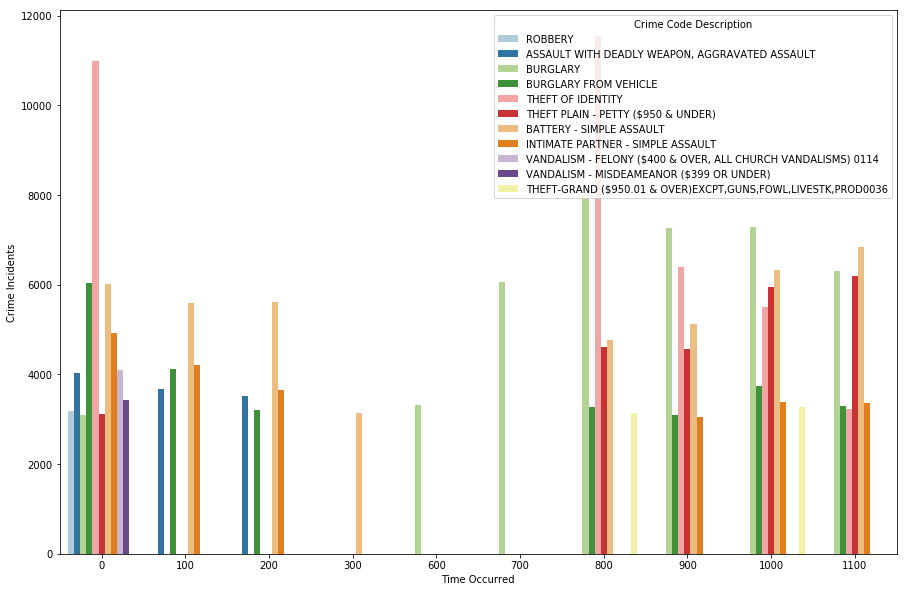

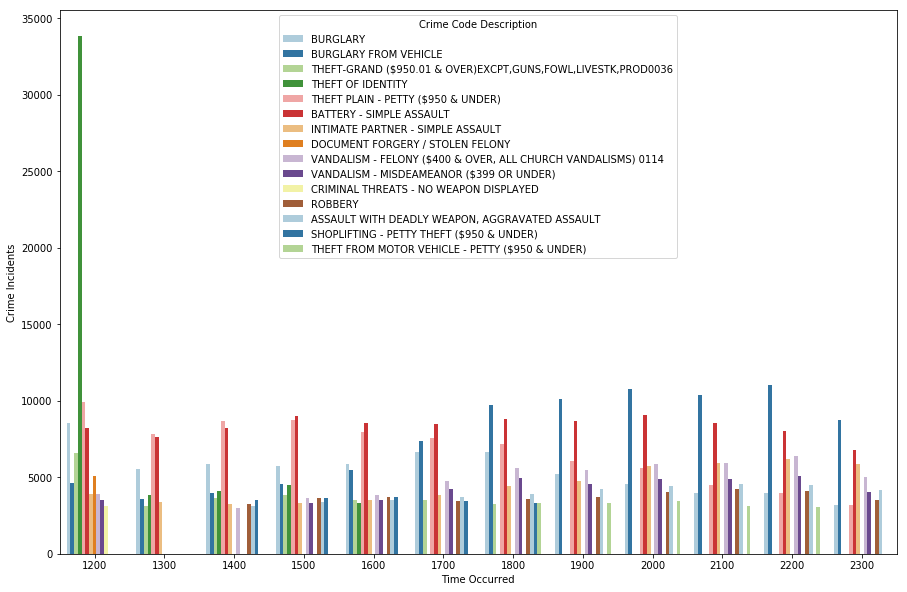

In [18]:
crimes['Time Occurred'] = crimes['Time Occurred'].map(lambda x: map_times(x))

crime_time = crimes.groupby([crimes['Time Occurred'], crimes['Crime Code'], crimes['Crime Code Description']])
crime_time = pd.DataFrame({'Crime Incidents' : crime_time.size()}).reset_index()

plt.figure(figsize=(15, 10))
ax = sns.barplot( x='Time Occurred', y='Crime Incidents', hue='Crime Code Description',
            data=crime_time[(crime_time['Crime Incidents']>3000) & (crime_time['Time Occurred']<1200)], palette=color_palette)

plt.figure(figsize=(15, 10))
ax = sns.barplot( x='Time Occurred', y='Crime Incidents', hue='Crime Code Description',
            data=crime_time[(crime_time['Crime Incidents']>3000) & (crime_time['Time Occurred']>=1200)], palette=color_palette)

Interesting patterns. TODO Interpret

In [19]:
crime_year = crimes.groupby([crimes['Date Occurred'].dt.year, crimes['Crime Code'], crimes['Crime Code Description']])
crime_year = pd.DataFrame({'Crime Incidents' : crime_year.size()}).reset_index()

crime_year.head()

,Date Occurred,Crime Code,Crime Code Description,Crime Incidents
0,2010,110,CRIMINAL HOMICIDE,291
1,2010,113,"MANSLAUGHTER, NEGLIGENT",1
2,2010,121,"RAPE, FORCIBLE",890
3,2010,122,"RAPE, ATTEMPTED",137
4,2010,210,ROBBERY,9551


In [20]:
@interact(year=(2010,2017,1))
def show_distplot(year):  
    crime_year = crimes.groupby([crimes['Date Occurred'].dt.year, crimes['Weapon Used Code'],
                                 crimes['Weapon Description']])
    crime_year = pd.DataFrame({'Crime Incidents' : crime_year.size()}).reset_index()
    
    crime_year = crime_year[(crime_year['Date Occurred'] >= year)&
                        (crime_year['Date Occurred'] <= year)&(crime_year['Weapon Used Code']!=222.0)]
    
    plt.figure(figsize=(10, 10))
    sns.barplot(x='Crime Incidents', y='Weapon Description', data=crime_year.sort_values(ascending=False, 
                                                                                         by='Crime Incidents').head(10));


interactive(children=(IntSlider(value=2013, description='year', max=2017, min=2010), Output()), _dom_classes=('widget-interact',))

### Descent and Crime

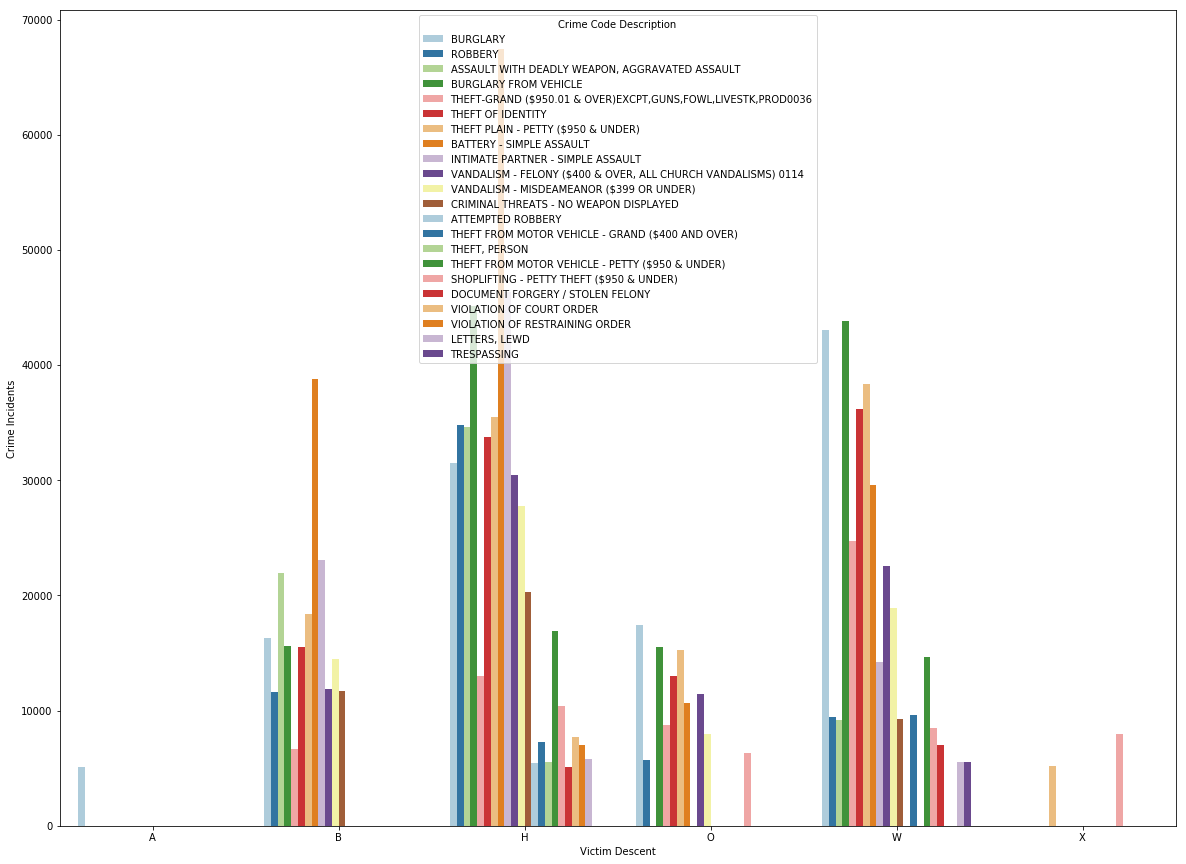

In [21]:
crime_descent = crimes.groupby([crimes['Victim Descent'], crimes['Crime Code'], crimes['Crime Code Description']])

crime_descent = pd.DataFrame({'Crime Incidents' : crime_descent.size()}).reset_index()

color_palette = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928']

plt.figure(figsize=(20, 15))
ax = sns.barplot( x='Victim Descent', y='Crime Incidents', hue='Crime Code Description',
            data=crime_descent[crime_descent['Crime Incidents']>5000], palette=color_palette)

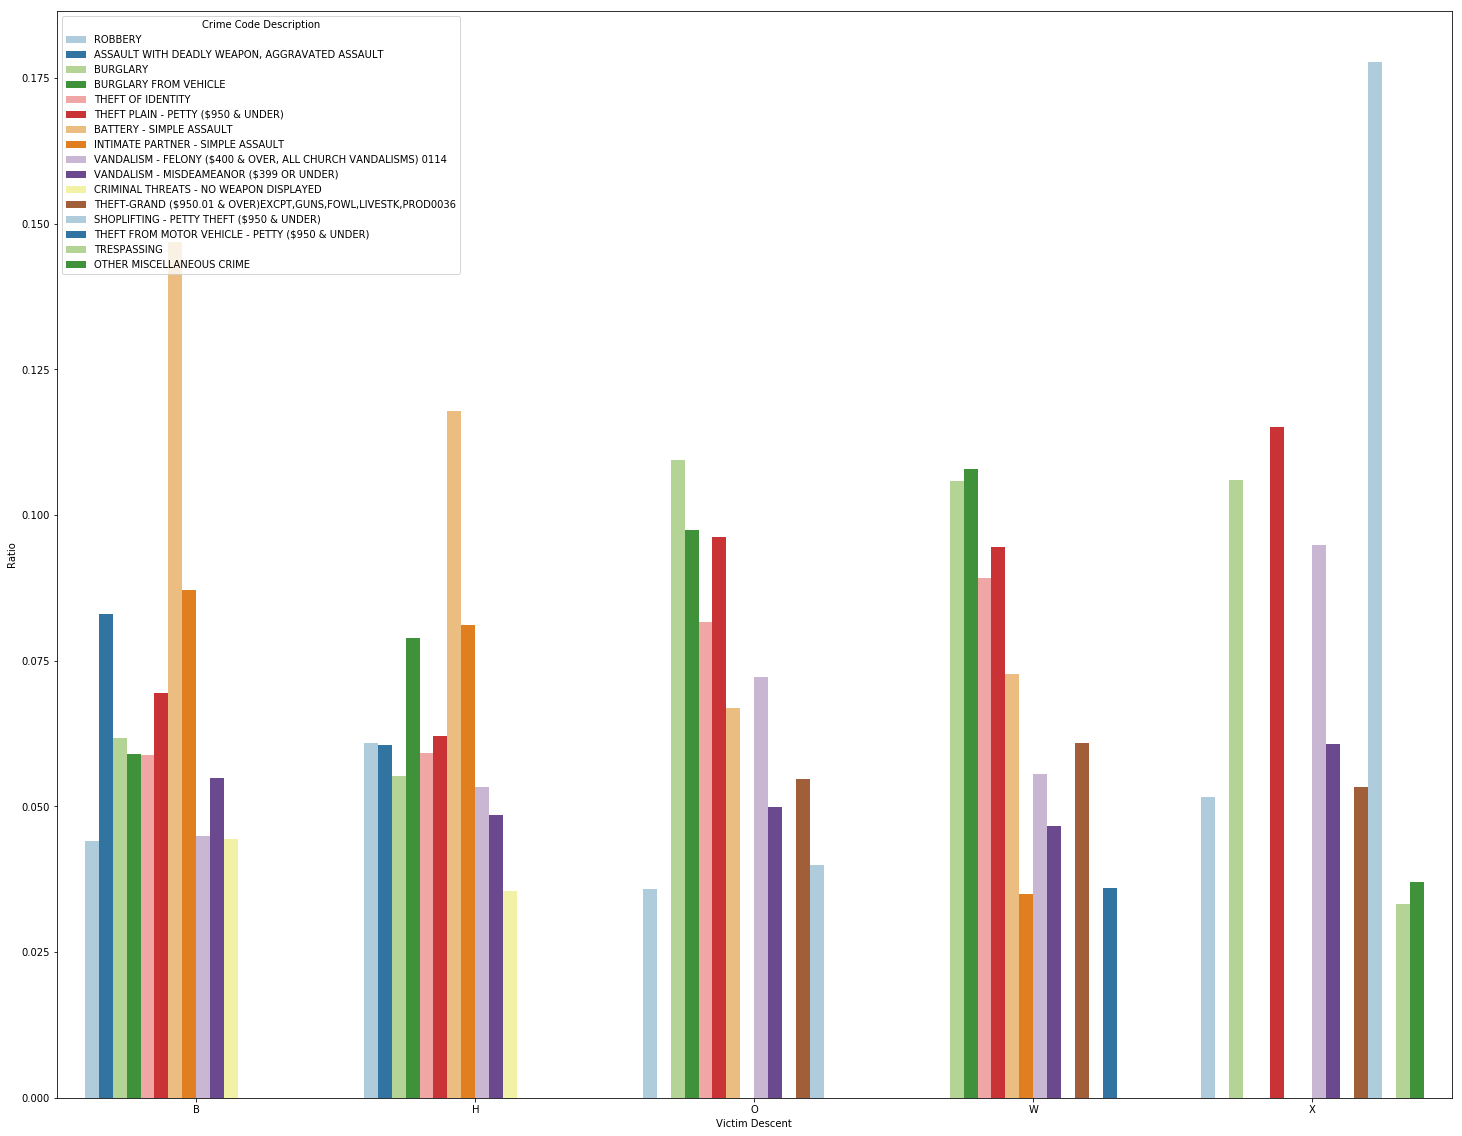

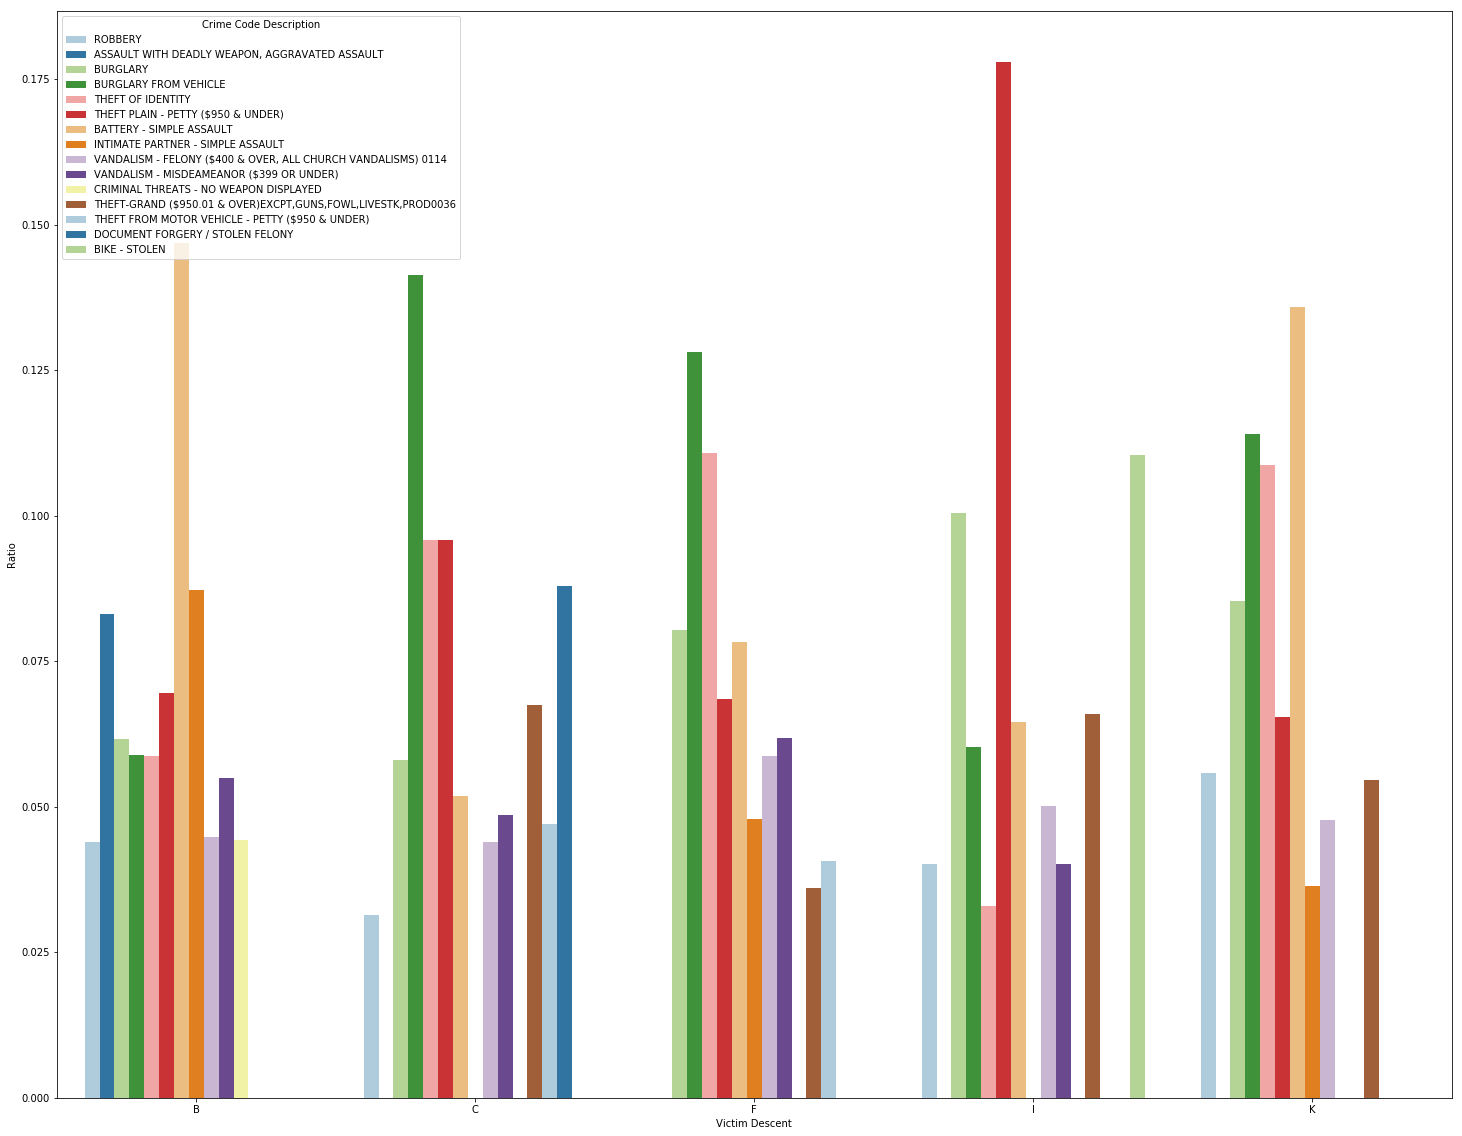

In [22]:
total_incidents = crime_descent.groupby('Victim Descent')['Crime Incidents'].sum()
crime_descent['Ratio']=crime_descent.apply(lambda x: x['Crime Incidents']/total_incidents[x['Victim Descent']], axis=1)

descent = ['B', 'W', 'O', 'A', 'X']


plt.figure(figsize=(25, 20))
ax = sns.barplot( x='Victim Descent', y='Ratio', hue='Crime Code Description',
            data=crime_descent[(crime_descent['Ratio']>0.03)&((crime_descent['Victim Descent']=='H')|(crime_descent['Victim Descent']=='W')
                               |(crime_descent['Victim Descent']=='B')|(crime_descent['Victim Descent']=='O')|(crime_descent['Victim Descent']=='X'))], palette=color_palette)


plt.figure(figsize=(25, 20))
ax = sns.barplot( x='Victim Descent', y='Ratio', hue='Crime Code Description',
            data=crime_descent[(crime_descent['Ratio']>0.03)&((crime_descent['Victim Descent']=='K')|(crime_descent['Victim Descent']=='F')
                               |(crime_descent['Victim Descent']=='I')|(crime_descent['Victim Descent']=='C')|(crime_descent['Victim Descent']=='B'))], palette=color_palette)

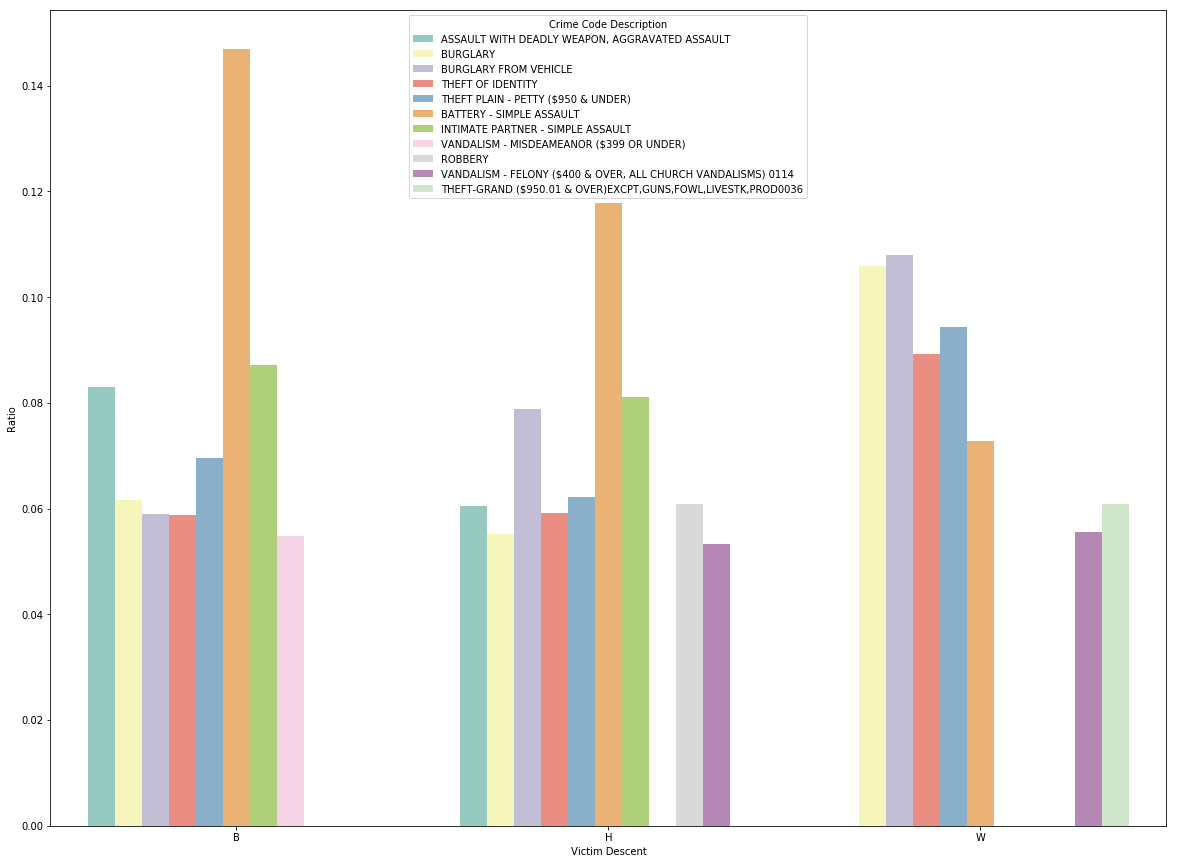

In [23]:
plt.figure(figsize=(20, 15))
ax = sns.barplot( x='Victim Descent', y='Ratio', hue='Crime Code Description',
            data=crime_descent[((crime_descent['Victim Descent']=='H')|(crime_descent['Victim Descent']=='B')
                                |(crime_descent['Victim Descent']=='W'))&(crime_descent['Ratio']>0.05)],
                 palette=sns.color_palette("Set3", 13))



TODO INTERPRET AND PLOT BETTER
There seems to be a difference between crime types and descent

### Correlation between crime and sex

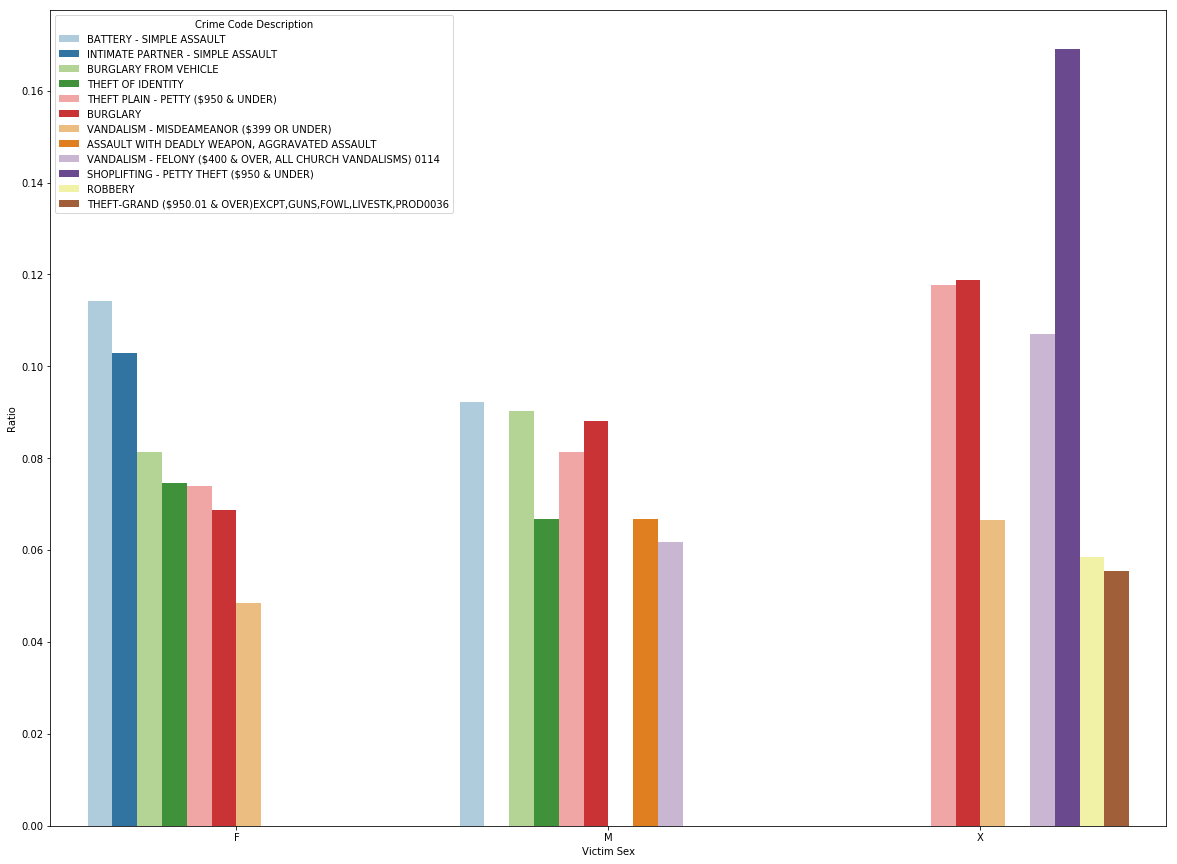

In [24]:
crime_sex = crimes.groupby([crimes['Victim Sex'], crimes['Crime Code'], crimes['Crime Code Description']])
crime_sex  = pd.DataFrame({'Crime Incidents' : crime_sex .size()}).reset_index()

total_incidents = crime_sex.groupby('Victim Sex')['Crime Incidents'].sum()
crime_sex['Ratio']=crime_sex.apply(lambda x: x['Crime Incidents']/total_incidents[x['Victim Sex']], axis=1)


crime_sex = crime_sex.sort_values(by=['Victim Sex','Ratio'],ascending=[True, False])

crime_sex_top3 = crime_sex.groupby('Victim Sex').head(7)

color_palette = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928']

plt.figure(figsize=(20, 15))
ax = sns.barplot( x='Victim Sex', y='Ratio', hue='Crime Code Description',
            data=crime_sex_top3, palette=color_palette)

TODO INTERPRET, there is a difference manly inbattery and intimate partner

### Age and Crime

In [25]:
def map_age_group(x):
    if x<20:
        return '10-20'
    if x<30:
        return '20-30'
    if x<50:
        return '30-50'
    if x<70:
        return '50-70'
    
    return '70-99'
crime_age = crimes.groupby([crimes['Victim Age'], crimes['Crime Code'], crimes['Crime Code Description']])
crime_age  = pd.DataFrame({'Crime Incidents' : crime_age .size()}).reset_index()
crime_age['Victim Age']=crime_age['Victim Age'].map(lambda x: map_age_group(x))


In [26]:
crime_age = crime_age.groupby([crime_age['Victim Age'], crime_age['Crime Code'], 
                               crime_age['Crime Code Description']]).count()

crime_age


Victim Age  \
Victim Age Crime Code Crime Code Description                                           
10-20      110        CRIMINAL HOMICIDE                                           10   
           113        MANSLAUGHTER, NEGLIGENT                                      1   
           121        RAPE, FORCIBLE                                              10   
           122        RAPE, ATTEMPTED                                              9   
           210        ROBBERY                                                     10   
           220        ATTEMPTED ROBBERY                                           10   
           230        ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT              10   
           231        ASSAULT WITH DEADLY WEAPON ON POLICE OFFICER                 9   
           235        CHILD ABUSE (PHYSICAL) - AGGRAVATED ASSAULT                  9   
           236        INTIMATE PARTNER - AGGRAVATED ASSAULT                        8   
           237        CHILD NEGLECT (SEE 300 W.I.C.)                              10   
           250        SHOTS FIRED AT MOVING VEHICLE, TRAIN OR AIRCRAFT             9   
           251        SHOTS FIRED AT INHABITED DWELLING                           10   
           310        BURGLARY                                                    10   
           320        BURGLARY, ATTEMPTED                                         10   
           330        BURGLARY FROM VEHICLE                                       10   
           331        THEFT FROM MOTOR VEHICLE - GRAND ($400 AND OVER)            10   
           341        THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIV...          10   
           343        SHOPLIFTING-GRAND THEFT ($950.01 & OVER)                    10   
           345        DISHONEST EMPLOYEE - GRAND THEFT                             7   
           347        GRAND THEFT / INSURANCE FRAUD                                4   
           349        GRAND THEFT / AUTO REPAIR                                    2   
           350        THEFT, PERSON                                               10   
           351        PURSE SNATCHING                                              9   
           352        PICKPOCKET                                                  10   
           353        DRUNK ROLL                                                   1   
           354        THEFT OF IDENTITY                                           10   
           410        BURGLARY FROM VEHICLE, ATTEMPTED                            10   
           420        THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)             10   
           421        THEFT FROM MOTOR VEHICLE - ATTEMPT                           6   
...                                                                              ...   
70-99      820        ORAL COPULATION                                              6   
           821        SODOMY/SEXUAL CONTACT B/W PENIS OF ONE PERS TO ...           4   
           830        INCEST (SEXUAL ACTS BETWEEN BLOOD RELATIVES)                 1   
           850        INDECENT EXPOSURE                                           16   
           860        BATTERY WITH SEXUAL CONTACT                                 24   
           882        INCITING A RIOT                                              1   
           884        FAILURE TO DISPERSE                                          2   
           886        DISTURBING THE PEACE                                        18   
           888        TRESPASSING                                                 29   
           900        VIOLATION OF COURT ORDER                                    27   
           901        VIOLATION OF RESTRAINING ORDER                              27   
           902        VIOLATION OF TEMPORARY RESTRAINING ORDER                    16   
           903        CONTEMPT OF COURT                                           19   
           910        KIDN

### Crimes in certain areas

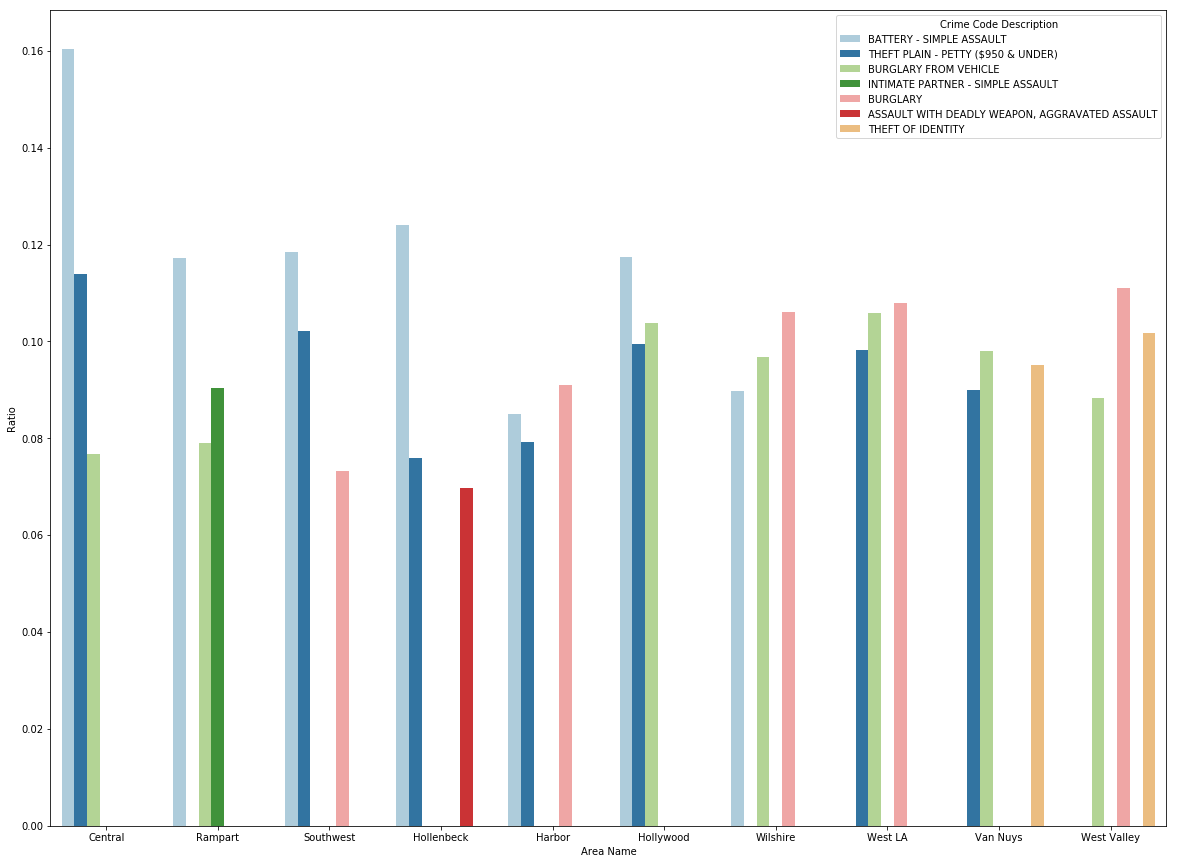

In [27]:
crime_area = crimes.groupby(['Area ID', 'Area Name', 'Crime Code Description'])
crime_area = pd.DataFrame({'Crime Incidents':crime_area.size()}).reset_index()

total_incidents = crime_area.groupby(['Area ID'])['Crime Incidents'].sum()
crime_area['Ratio']=crime_area.apply(lambda x: x['Crime Incidents']/total_incidents[x['Area ID']], axis=1)

crime_area = crime_area.sort_values(by=['Area ID','Ratio'],ascending=[True, False])

crime_area_top3 = crime_area.groupby('Area ID').head(3)
crime_area_top3

plt.figure(figsize=(20, 15))
ax = sns.barplot( x='Area Name', y='Ratio', hue='Crime Code Description',
            data=crime_area_top3[:30], palette=color_palette)

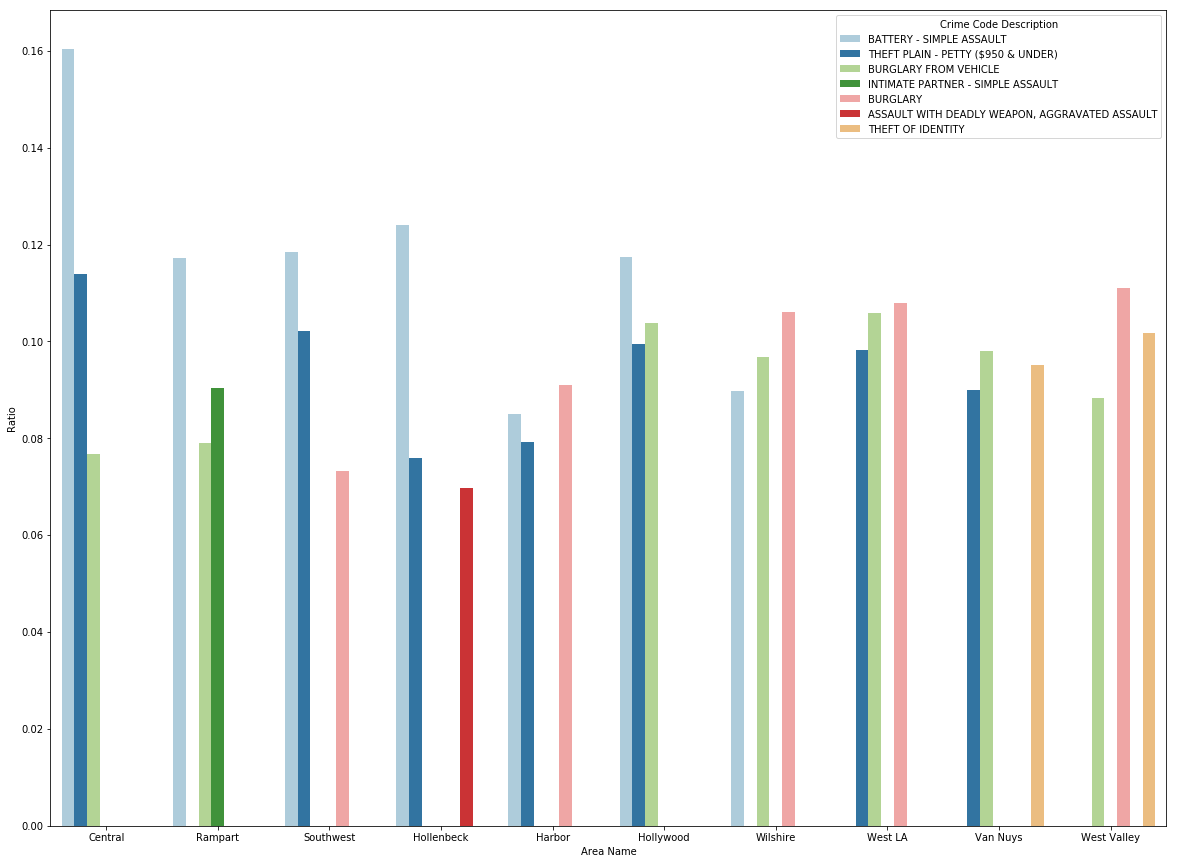

In [28]:
crime_area = crimes.groupby(['Area ID', 'Area Name', 'Crime Code Description'])
crime_area = pd.DataFrame({'Crime Incidents':crime_area.size()}).reset_index()

total_incidents = crime_area.groupby(['Area ID'])['Crime Incidents'].sum()
crime_area['Ratio']=crime_area.apply(lambda x: x['Crime Incidents']/total_incidents[x['Area ID']], axis=1)

crime_area = crime_area.sort_values(by=['Area ID','Ratio'],ascending=[True, False])

crime_area_top3 = crime_area.groupby('Area ID').head(3)
crime_area_top3

plt.figure(figsize=(20, 15))
ax = sns.barplot( x='Area Name', y='Ratio', hue='Crime Code Description',
            data=crime_area_top3[:30], palette=color_palette)

In [36]:

crime_area = crimes.groupby(['Area ID', 'Area Name', 'Crime Code Description'])
crime_area = pd.DataFrame({'Crime Incidents':crime_area.size()}).reset_index()

total_incidents = crime_area.groupby(['Area ID'])['Crime Incidents'].sum()
crime_area['Ratio']=crime_area.apply(lambda x: x['Crime Incidents']/total_incidents[x['Area ID']], axis=1)

crime_area = crime_area.sort_values(by=['Area ID','Ratio'],ascending=[True, False])

@interact(top_crimes=(1,10,1), area=['Central', 'Rampart', 'Southwest', 'Hollenbeck', 'Harbor', 'Hollywood', 'Wilshire', 'West LA', 'Van Nuys', 'West Valley'])
def show_distplot(area,top_crimes):  
    
    crime_area_top = crime_area[(crime_area['Area Name']==area)].groupby('Area ID').head(top_crimes)
    plt.figure(figsize=(20, 10))
    ax = sns.barplot( x='Area Name', y='Ratio', hue='Crime Code Description',
            data=crime_area_top, palette=color_palette)
   

interactive(children=(Dropdown(description='area', options=('Central', 'Rampart', 'Southwest', 'Hollenbeck', 'Harbor', 'Hollywood', 'Wilshire', 'West LA', 'Van Nuys', 'West Valley'), value='Central'), IntSlider(value=5, description='top_crimes', max=10, min=1), Output()), _dom_classes=('widget-interact',))

## Clustering